In [2]:
!pip install tensorflow tensorflow-datasets matplotlib pillow numpy
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw, ImageFont
IMG_W = 75
IMG_H = 75


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 6.7 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 6.8 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 6.7 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 6.7 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.3 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 6.4 MB/s eta 0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ----------

In [3]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', thickness=1, display_str=None,
                               use_normalized_coordinates=True):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        left = xmin * im_width
        right = xmax * im_width
        top = ymin * im_height
        bottom = ymax * im_height
    else:
        left, right, top, bottom = xmin, xmax, ymin, ymax

    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)
    if display_str:
        try:
            font = ImageFont.load_default()
            text_size = draw.textsize(display_str, font=font)
            text_origin = (left, max(0, top - text_size[1]))
            draw.rectangle([text_origin, (text_origin[0] + text_size[0], text_origin[1] + text_size[1])],
                           fill=color)
            draw.text(text_origin, display_str, fill='white', font=font)
        except Exception:
            pass

def draw_bounding_boxes_on_image_array(image_array, boxes, colors=None, thickness=1, display_str_list=None):
    """
    image_array: H x W or H x W x C (0..255 or 0..1)
    boxes: numpy [N,4] with each box [xmin,ymin,xmax,ymax] normalized
    """
    img = image_array
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    pil_img = Image.fromarray(img)

    if boxes is None or boxes.size == 0:
        return np.array(pil_img)

    if colors is None:
        colors = ['red'] * len(boxes)
    if display_str_list is None:
        display_str_list = [None] * len(boxes)

    for i, b in enumerate(boxes):
        xmin, ymin, xmax, ymax = b
        draw_bounding_box_on_image(pil_img, ymin, xmin, ymax, xmax,
                                   color=colors[i], thickness=thickness, display_str=display_str_list[i],
                                   use_normalized_coordinates=True)
    return np.array(pil_img)


In [8]:
def read_image_tfds(image, label):
    xmin_px = tf.random.uniform([], 0, IMG_W - 28, dtype=tf.int32)
    ymin_px = tf.random.uniform([], 0, IMG_H - 28, dtype=tf.int32)

    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin_px, xmin_px, IMG_H, IMG_W)
    image = tf.cast(image, tf.float32) / 255.0

    xmin = tf.cast(xmin_px, tf.float32) / IMG_W
    ymin = tf.cast(ymin_px, tf.float32) / IMG_H
    xmax = (tf.cast(xmin_px, tf.float32) + 28.0) / IMG_W
    ymax = (tf.cast(ymin_px, tf.float32) + 28.0) / IMG_H

    one_hot = tf.one_hot(label, 10)
    bbox = tf.stack([xmin, ymin, xmax, ymax])  # [xmin,ymin,xmax,ymax]
    return image, (one_hot, bbox)

def get_training_dataset(batch_size):
    ds = tfds.load("mnist", split="train", as_supervised=True, try_gcs=False, download=True)
    ds = ds.map(lambda im,lb: read_image_tfds(im, lb), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(5000).repeat().batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

def get_validation_dataset():
    ds = tfds.load("mnist", split="test", as_supervised=True, try_gcs=False, download=True)
    ds = ds.map(lambda im,lb: read_image_tfds(im, lb), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(10000, drop_remainder=True).repeat()
    return ds


def dataset_to_numpy_util(training_dataset, validation_dataset, N=10):
    for batch in validation_dataset.take(1):
        val_images, (val_labels_onehot, val_bboxes) = batch
        val_images = val_images[:N].numpy()
        val_labels = np.argmax(val_labels_onehot[:N].numpy(), axis=1)
        val_bboxes = val_bboxes[:N].numpy()
        break

    for batch in training_dataset.take(1):
        tr_images, (tr_labels_onehot, tr_bboxes) = batch
        tr_images = tr_images[:N].numpy()
        tr_labels = np.argmax(tr_labels_onehot[:N].numpy(), axis=1)
        tr_bboxes = tr_bboxes[:N].numpy()
        break

    return (tr_images, tr_labels, tr_bboxes, val_images, val_labels, val_bboxes)


In [9]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, true_bboxes, iou, title, iou_threshold=0.6):
    n = min(10, len(predictions))
    indices = np.random.choice(len(predictions), size=n, replace=False)
    fig = plt.figure(figsize=(20, 4))
    plt.suptitle(title)
    for j, idx in enumerate(indices):
        ax = fig.add_subplot(1, n, j + 1)
        img = (digits[idx].squeeze() * 255.0).astype(np.uint8)
        img_rgb = np.stack([img, img, img], axis=-1)

        boxes_to_plot = []
        colors = []
        labels_str = []

        if pred_bboxes is not None and getattr(pred_bboxes, "size", 0):
            boxes_to_plot.append(pred_bboxes[idx])
            colors.append('red')
            labels_str.append(f'P:{predictions[idx]}')
        if true_bboxes is not None and getattr(true_bboxes, "size", 0):
            boxes_to_plot.append(true_bboxes[idx])
            colors.append('green')
            labels_str.append(f'T:{labels[idx]}')

        img_with_boxes = draw_bounding_boxes_on_image_array(img_rgb, np.array(boxes_to_plot),
                                                           colors, thickness=1, display_str_list=labels_str)
        ax.imshow(img_with_boxes)
        ax.axis('off')
        if predictions[idx] != labels[idx]:
            ax.set_title(f'P:{predictions[idx]} / T:{labels[idx]}', color='red')
        else:
            ax.set_title(f'P:{predictions[idx]} / T:{labels[idx]}')

        if iou is not None and len(iou) > idx:
            try:
                ax.text(0.5, -0.2, f'iou: {iou[idx][0]:.3f}', transform=ax.transAxes)
            except Exception:
                pass
    plt.show()

def intersection_over_union(pred_box, true_box):
    eps = 1e-10
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    overlap_w = np.maximum(0.0, xmax_overlap - xmin_overlap)
    overlap_h = np.maximum(0.0, ymax_overlap - ymin_overlap)
    overlap_area = overlap_w * overlap_h

    pred_area = np.maximum(0.0, (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred))
    true_area = np.maximum(0.0, (xmax_true - xmin_true) * (ymax_true - ymin_true))

    union_area = pred_area + true_area - overlap_area
    iou = (overlap_area + eps) / (union_area + eps)
    return iou


In [10]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3, padding='same')(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)
    return x

def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

def classifier(inputs):
    return tf.keras.layers.Dense(10, activation='softmax', name='classification')(inputs)

def bounding_box_regression(inputs):
    return tf.keras.layers.Dense(4, name='bounding_box')(inputs)

def final_model():
    inputs = tf.keras.layers.Input(shape=(IMG_H, IMG_W, 1))
    feat = feature_extractor(inputs)
    dense = dense_layers(feat)
    cls = classifier(dense)
    bbox = bounding_box_regression(dense)
    return tf.keras.Model(inputs=inputs, outputs=[cls, bbox])

def define_and_compile_model():
    model = final_model()
    model.compile(optimizer='adam',
                  loss={'classification': 'categorical_crossentropy', 'bounding_box': 'mse'},
                  metrics={'classification': 'accuracy', 'bounding_box': 'mse'})
    return model


Num replicas: 1


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to C:\Users\DEVANSH\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 75, 75, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 75, 75, 16)        │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d             │ (None, 37, 37, 16)        │               0 │ conv2d[0][0]               │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 37, 37, 32)        │           4,640 │ average_pooling2d[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_1           │ (None, 18, 18, 32)        │               0 │ conv2d_1[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 18, 18, 64)        │          18,496 │ average_pooling2d_1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_2           │ (None, 9, 9, 64)          │               0 │ conv2d_2[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 5184)              │               0 │ average_pooling2d_2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         663,680 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification (Dense)        │ (None, 10)                │           1,290 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bounding_box (Dense)          │ (None, 4)                 │             516 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 688,782 (2.63 MB)

 Trainable params: 688,782 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

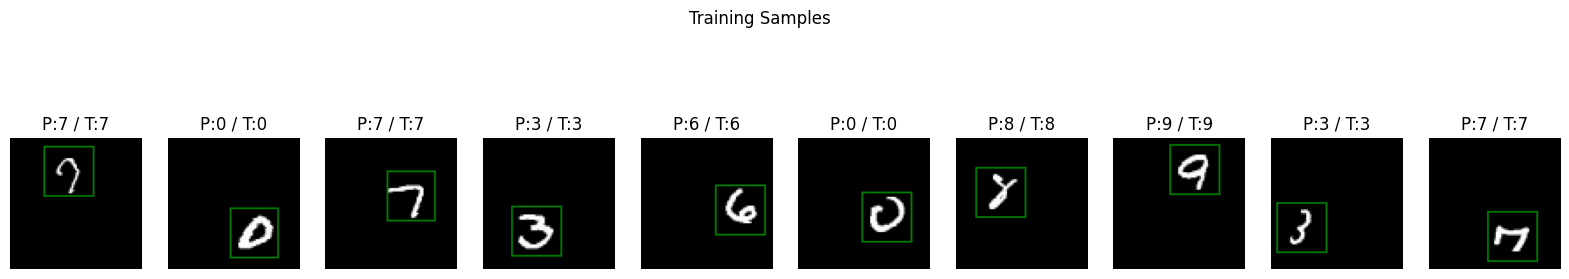

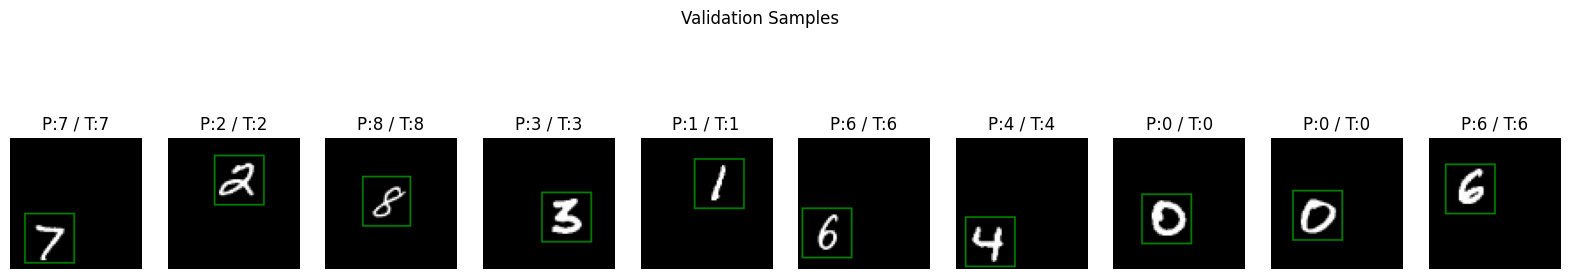

Epoch 1/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 127s 131ms/step - bounding_box_loss: 0.0127 - bounding_box_mse: 0.0127 - classification_accuracy: 0.6797 - classification_loss: 0.9247 - loss: 0.9375 - val_bounding_box_loss: 0.0067 - val_bounding_box_mse: 0.0067 - val_classification_accuracy: 0.9209 - val_classification_loss: 0.2668 - val_loss: 0.2734
Epoch 2/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 129s 137ms/step - bounding_box_loss: 0.0053 - bounding_box_mse: 0.0053 - classification_accuracy: 0.9275 - classification_loss: 0.2441 - loss: 0.2494 - val_bounding_box_loss: 0.0039 - val_bounding_box_mse: 0.0039 - val_classification_accuracy: 0.9494 - val_classification_loss: 0.1619 - val_loss: 0.1658
Epoch 3/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 134s 142ms/step - bounding_box_loss: 0.0032 - bounding_box_mse: 0.0032 - classification_accuracy: 0.9476 - classification_loss: 0.1729 - loss: 0.1761 - val_bounding_box_loss: 0.0030 - val_bounding_box_mse: 0.0030 - val_classification_accuracy: 0.9542 - val_classification_los

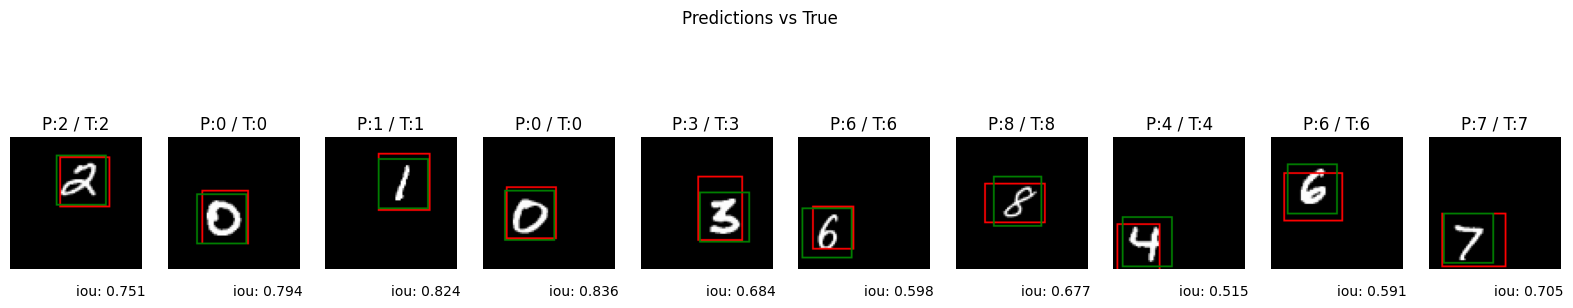

In [11]:
strategy = tf.distribute.get_strategy()
print("Num replicas:", strategy.num_replicas_in_sync)
BATCH_SIZE = 64 * max(1, strategy.num_replicas_in_sync)

training_dataset = get_training_dataset(BATCH_SIZE)
validation_dataset = get_validation_dataset()

with strategy.scope():
    model = define_and_compile_model()
model.summary()

tr_imgs, tr_labels, tr_bboxes, val_imgs, val_labels, val_bboxes = dataset_to_numpy_util(training_dataset, validation_dataset, N=10)
display_digits_with_boxes(tr_imgs, tr_labels, tr_labels, np.array([]), tr_bboxes, None, "Training Samples")
display_digits_with_boxes(val_imgs, val_labels, val_labels, np.array([]), val_bboxes, None, "Validation Samples")

EPOCHS = 5
steps_per_epoch = 60000 // BATCH_SIZE
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset, validation_steps=1, epochs=EPOCHS)

val_metrics = model.evaluate(validation_dataset, steps=1)
print("Validation metrics:", val_metrics)

preds = model.predict(val_imgs, batch_size=64)
pred_labels = np.argmax(preds[0], axis=1)
pred_bboxes = preds[1]
iou = intersection_over_union(pred_bboxes, val_bboxes)
display_digits_with_boxes(val_imgs, pred_labels, val_labels, pred_bboxes, val_bboxes, iou, "Predictions vs True")
